In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ml = pd.read_json("https://storage.googleapis.com/geospiza/query/maplelegends-online-count.json")

In [17]:
ml.timestamp = ml.timestamp.dt.round("15min")
ml = ml[ml.timestamp >= "2020-07"]
ml

timestamp  usercount
0     2021-08-06 16:00:00+00:00       1147
1     2021-08-06 15:45:00+00:00       1153
2     2021-08-06 15:30:00+00:00       1153
3     2021-08-06 15:15:00+00:00       1135
4     2021-08-06 15:00:00+00:00       1079
...                         ...        ...
38450 2020-07-01 01:15:00+00:00       1947
38451 2020-07-01 01:00:00+00:00       1913
38452 2020-07-01 00:45:00+00:00       1864
38453 2020-07-01 00:30:00+00:00       1844
38454 2020-07-01 00:15:00+00:00       1819

[38455 rows x 2 columns]

In [40]:
start, end = ml.timestamp.min(), ml.timestamp.max()
ds_range = pd.date_range(start, end, freq="15T")
canon_dates = pd.DataFrame(ds_range, columns=["timestamp"])

df = (
    ml
    .groupby("timestamp")
    .min()
    .reset_index()
    .merge(canon_dates, on="timestamp", how="right")
    .fillna(0)
    .sort_values("timestamp")
)

med = df.usercount.median()
mad = (df.usercount - med).abs().median()
k = 1/.6745
df["score"] = (df.usercount - med)/(k*mad)
df["normed"] = df.usercount
df.loc[(df.score.abs() > 3) | (df.usercount == 0), "normed"] = np.nan

In [41]:
df.normed.isnull().sum()

1178

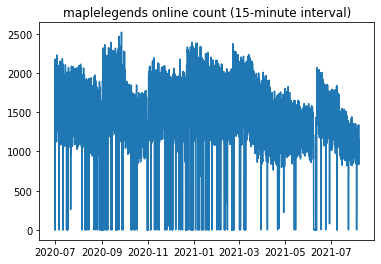

In [42]:
plt.plot(df.timestamp, df.usercount)
plt.title("maplelegends online count (15-minute interval)")
plt.show()

In [43]:
df.normed.interpolate()

0        1819.0
1        1844.0
2        1864.0
3        1913.0
4        1947.0
          ...  
38555    1079.0
38556    1135.0
38557    1153.0
38558    1153.0
38559    1147.0
Name: normed, Length: 38560, dtype: float64

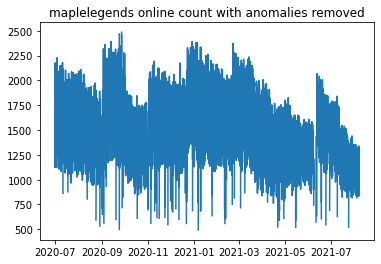

In [44]:
plt.plot(df.timestamp, df.normed)
plt.title("maplelegends online count with anomalies removed")
plt.show()

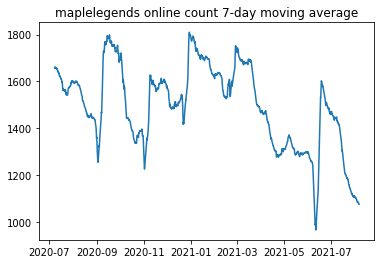

In [45]:
plt.plot(df.timestamp, df.normed.interpolate().rolling(4*24*7).mean())
plt.title("maplelegends online count 7-day moving average")
plt.show()

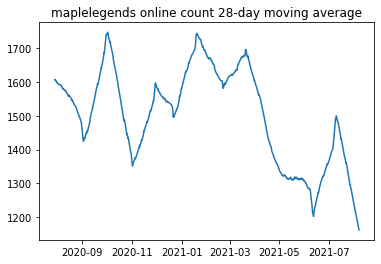

In [46]:
plt.plot(df.timestamp, df.normed.interpolate().rolling(4*24*28).mean())
plt.title("maplelegends online count 28-day moving average")
plt.show()

In [47]:
sub = df[df.score.abs() > 3]
len(sub)/4, len(sub)/4/24

(294.5, 12.270833333333334)

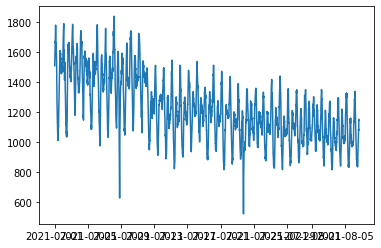

In [48]:
x = df[(df.score.abs() < 3)&(df.timestamp > "2021-07")]
plt.plot(x.timestamp, x.usercount)
plt.show()

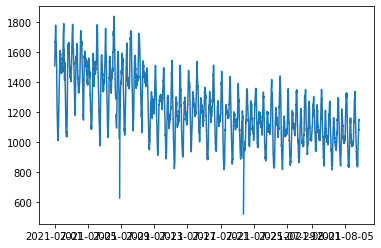

In [49]:
x = df[df.timestamp > "2021-07"]
plt.plot(x.timestamp, x.normed)
plt.show()

In [71]:
T = len(df)
# L = int(N**(1/2))
# N = int(T**(2/3))
L = 4 * 24 * 7
N = T // L
T, L, N, N*L

(38560, 672, 57, 38304)

In [72]:
a, b = df.normed.min(), df.normed.max()
a, b

(494.0, 2485.0)

In [83]:
offset = T-(T//N*N)
Y = df[offset:].normed.interpolate().values.reshape(N, -1) 
Y = (Y - ((a+b)/2))/((b-a)/2)
Y.shape

(57, 676)

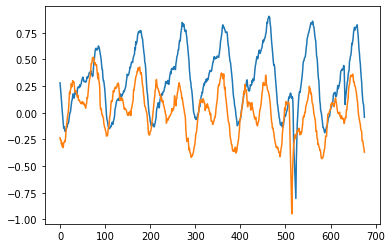

In [84]:
plt.plot(Y[25])
plt.plot(Y[50])
# plt.plot(Y[100])
# plt.plot(Y[150])
# plt.plot(Y[175])
plt.show()

In [85]:
p_hat = ((df.score.abs() < 3) & (df.usercount != 0)).sum()/Y.size
p_hat

0.9701546766324094

In [86]:
Y.shape

(57, 676)

In [87]:
u, s, vh = np.linalg.svd(Y)

In [88]:
s

array([38.16998873, 27.604387  , 24.62872534, 17.39832449, 15.98707095,
       13.33941695,  9.65026353,  8.0900974 ,  6.88545134,  6.85796991,
        5.84646785,  5.43341729,  4.88409414,  4.53843466,  4.25836937,
        4.10561004,  3.73329428,  3.44690591,  3.37619926,  3.19967401,
        3.14402346,  3.04471252,  2.83095162,  2.68665059,  2.57407169,
        2.51613029,  2.34811356,  2.28319547,  2.17190812,  1.95983003,
        1.91429961,  1.87048187,  1.73589974,  1.70805497,  1.63847193,
        1.60140736,  1.49962052,  1.44721549,  1.38496801,  1.30581436,
        1.2232304 ,  1.19759077,  1.16748818,  1.13342831,  1.04856685,
        0.99319283,  0.95950905,  0.91408664,  0.87765406,  0.80875518,
        0.79922335,  0.74829313,  0.70107743,  0.6740273 ,  0.61760654,
        0.6041681 ,  0.58657086])

In [91]:
nu = 0.0001
s_hat = [x for x in s if x >= (2+nu)*np.sqrt(Y.shape[0]*p_hat)]
k = len(s_hat)
len(s), len(s_hat)

(57, 5)

In [92]:
M = (u[:,:k] * s[:k]).dot(vh[:k])/p_hat

In [93]:
M[M>1] = 1
M[M<-1] = -1
M_hat = M * (b-a)/2 + (a+b)/2

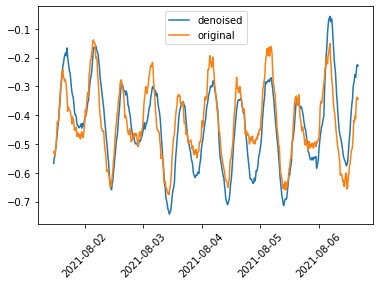

In [94]:
cut = 500
plt.plot(ds_range[-cut:], M.reshape(-1)[-cut:], label="denoised")
plt.plot(ds_range[-cut:], Y.reshape(-1)[-cut:], label="original")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [95]:
ds_range[-M.size:].shape

(38532,)

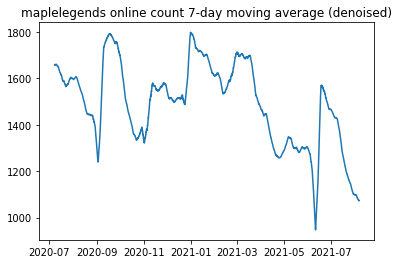

In [96]:
plt.plot(ds_range[-M_hat.size:], pd.Series(M_hat.reshape(-1)).rolling(4*24*7).mean())
plt.title("maplelegends online count 7-day moving average (denoised)")
plt.show()

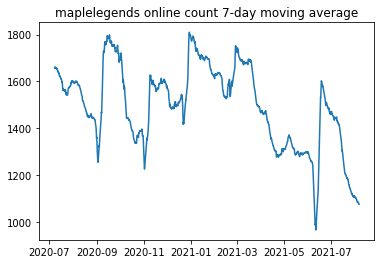

In [97]:
plt.plot(df.timestamp, df.normed.interpolate().rolling(4*24*7).mean())
plt.title("maplelegends online count 7-day moving average")
plt.show()

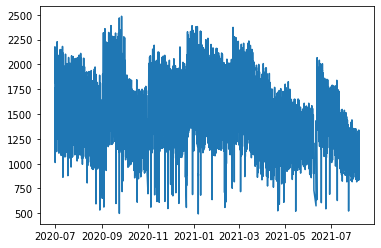

In [98]:
plt.plot(df.timestamp, df.normed.interpolate())
plt.show()

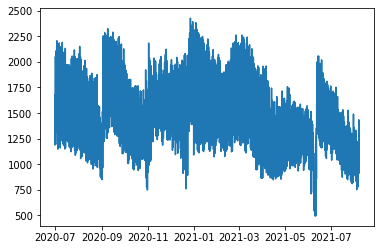

In [102]:
plt.plot(ds_range[-M_hat.size:], pd.Series(M_hat.reshape(-1)), label="denoised")
plt.show()